# GAN Tutorial

- Implementation of GAN from :
    - https://arxiv.org/abs/1406.2661
    - https://arxiv.org/abs/1511.06434
- Reference codes :
    - https://docs.pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    - https://github.com/eriklindernoren/PyTorch-GAN

## DCGAN?

For better performance, this tutorial implements DCGAN instead of Vanilla GAN

- Uses CNN for Generator and Discriminator (Not MLP)
    - Generator : latent vector --> ConvUpsampling --> Image Generation
    - Discriminator : Generated Image --> ConvDownsampling --> Probability value
- Basically same with vanilla GAN

### Architecture Guides for Stable DCGAN

- Replace pooling layers with strided convolutions($D$) and fractional-strided convolutions($G$)
- Use batchnorm in both the $D$ and the $G$
- Remove fully connected hidden layers for deeper architectures
- Use ReLU in $G$ for all layers except for the output, which uses $\tanh$
- Use LeakyReLU in the $D$ for all layers

### What do we need?

- Dataset : CelebA
- CNN structure (ResNet?)
- Discriminator
- Generator
- Loss function

In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel as parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import DataLoader
import numpy as np

## Model Hyperparameters

Basic Parameters

- Device : CPU / GPU ?
- Batch Size $B$
- Learning rate / Epochs
- Vector Dimensions
    - Latent dim($G$ input)
    -0 

CNN parameters

- Image $(B \times W \times H \times C)$
    - Size : $W \times H$
    - Channels $C$ ; Usually $3$ for RGB
- Filters

In [2]:
dataset_path = "~/datasets/CelebA"
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
epochs = 30
lr = 0.0002
latent_dim = 100

# Conv paprameters
image_size = 64 # W * H --> 64 * 64
channels = 3
filters = 64

## Data Preparation

### Celeb-A Faces dataset
Liu, Z., et al, "Deep Learning Face Attributes in the Wild," \
in Proceedings of International Conference on Computer Vision (ICCV), 2015.

- 10,177 number of identities
- 202,599 number of face images, and
- 5 landmark locations, 40 binary attributes annotations per image

According to tutorials ...

- We use only the face dataset for training
- Download the dataset 
    - https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
    - `img_align_celeba.zip` ; 1.3GB
- `mkdir` CelebA and extract zip file to the directory
- directory should be like below :

```bash
~/datasets/Celeba
    -> img_align_celeba
        -> 188242.jpg
        -> 173822.jpg
        -> 284702.jpg
        -> 537394.jpg
           ...
```

In [3]:
import os

p=os.path.expanduser("~/datasets/CelebA/img_align_celebA") 
print("exists" if os.path.isdir(p) else "NOT FOUND")
if not any(os.scandir(p)):
    print(p, "EMPTY")
else:
    n = sum(1 for _ in os.scandir(p))
    print(p, n, ", NOT_EMPTY")

exists
C:\Users\evana/datasets/CelebA/img_align_celebA 202599 , NOT_EMPTY


### Why making subdirectory `~/CelebA/img_align_celebA`?

- We use `ImageFolder` class in `torchvision.datasets as dataset`
- `ImageFolder` class
    - Requires subdirectories in root folder(`CelebA`)
    - Actual Work : Returns `(Image_tensor, label)`
    - We don't need the label, but anyway the class needs --> Make Subdirectory
    - Can use `torchvision.transforms`

In [4]:
dataset = datasets.ImageFolder(root = dataset_path,
                               transform = transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   # Normalizing valuse in each RGB Channels by 0 ~ 1 to -1 ~ +1
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ]))

kwargs = {'num_workers' : 2, 'pin_memory' : True}

# DataLoader 
dataloader = DataLoader(dataset, batch_size, shuffle = True, **kwargs)

### `transforms.Resize()`

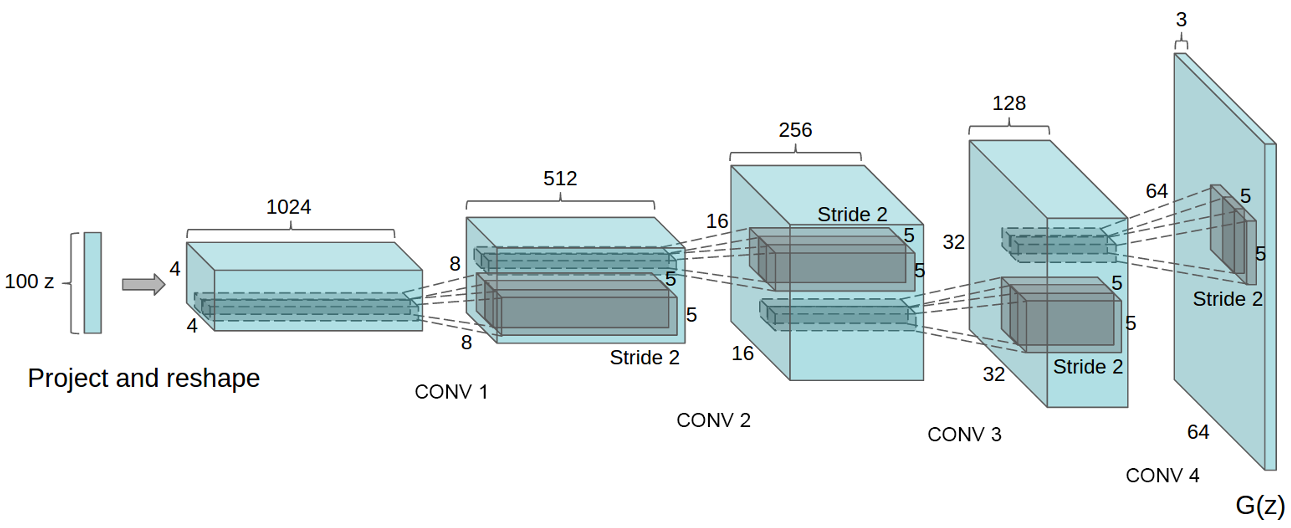
- Actual DCGAN Architecture Requires the image to be 64 * 64 size
- CelebA Face data : 178 * 218
- Resize the data !

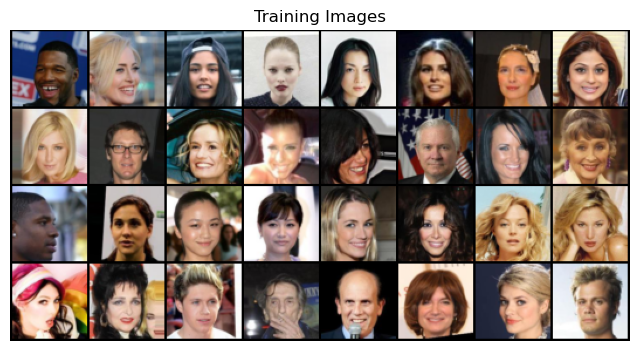

In [5]:
# Check some data in dataset

import matplotlib.pyplot as plt
import matplotlib.animation as animation

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(Device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## DCGAN Implemetation

### Weight Initialization

Check "4. DETAILS OF ADVERSARIAL TRAINING" in paper !

> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

- Weights are in `nn.Conv` and `nn.BatchNorm`
- $\mu = 0$
- $\sigma = 0.02$
- Note that BatchNorm parameters $\gamma, \beta$ are excluded in the paper's 'weights' 
    - Using 0.02 is usual anyway...

### How to customize the initialization the weights?

- Use `nn.init.xxx()` !
    - uniform_
    - normal_
    - etc...
    - Initialize the weight tensor by using the input value
- https://docs.pytorch.org/docs/stable/nn.init.html


In [6]:
import argparse

def weights_init(m):
    # m = torch __class__  = nn
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.002)
    elif classname.find("BatchNorm") != -1:
        # gamma --> 1.0 with std 0.02, (1.0, 0.0) is default
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        # beta --> 0 is default
        nn.init.constant_(m.bias.data, 0)

## Generator Impelemtation

Generator gradually converts $\mathbf z \in \mathbb R^{100}$ to $\boldsymbol X' = G(\mathbf z) \in \mathbb R^{64\times 64}$.\
Actual process is the reverse of usual CNN structure.
Check the image above !

- Project and reshaping
- CONV1
    - $(4, 4, 1024) \rightarrow (8, 8, 512)$
- CONV2
    - $(8, 8, 512) \rightarrow (8, 8, 256)$
    - stride = 2
- CONV3
    - $(16, 16, 256) \rightarrow (32, 32, 128)$
    - stride = 2
- CONV4
    - $(32, 32, 128) \rightarrow (64, 64, 3)$
    - stride = 2

# Still Working On...